## Instructions

In this challenge, you will create a book recommendation algorithm using K-Nearest Neighbors.

You will use the Book-Crossings dataset. This dataset contains 1.1 million ratings (scale of 1-10) of 270,000 books by 90,000 users.

After importing and cleaning the data, use NearestNeighbors from sklearn.neighbors to develop a model that shows books that are similar to a given book. The Nearest Neighbors algorithm measures distance to determine the “closeness” of instances.

Create a function named get_recommends that takes a book title (from the dataset) as an argument and returns a list of 5 similar books with their distances from the book argument.

## Solution

### Get Data Files

In [3]:
# get data files
!wget -N https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
!unzip -o book-crossings.zip


--2023-02-26 18:53:02--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: 'book-crossings.zip'

book-crossings.zip  100%[===================>]  24.88M  6.94MB/s    in 3.6s    

2023-02-26 18:53:05 (6.89 MB/s) - 'book-crossings.zip' saved [26085508/26085508]

Archive:  book-crossings.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


### Import libraries

In [1]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [3]:
books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

### Take a look at data

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 9) # (w, h)

df_books.head()

,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


Scatter plot for the number of rating of each user

<AxesSubplot:xlabel='user', ylabel='rating_log10'>

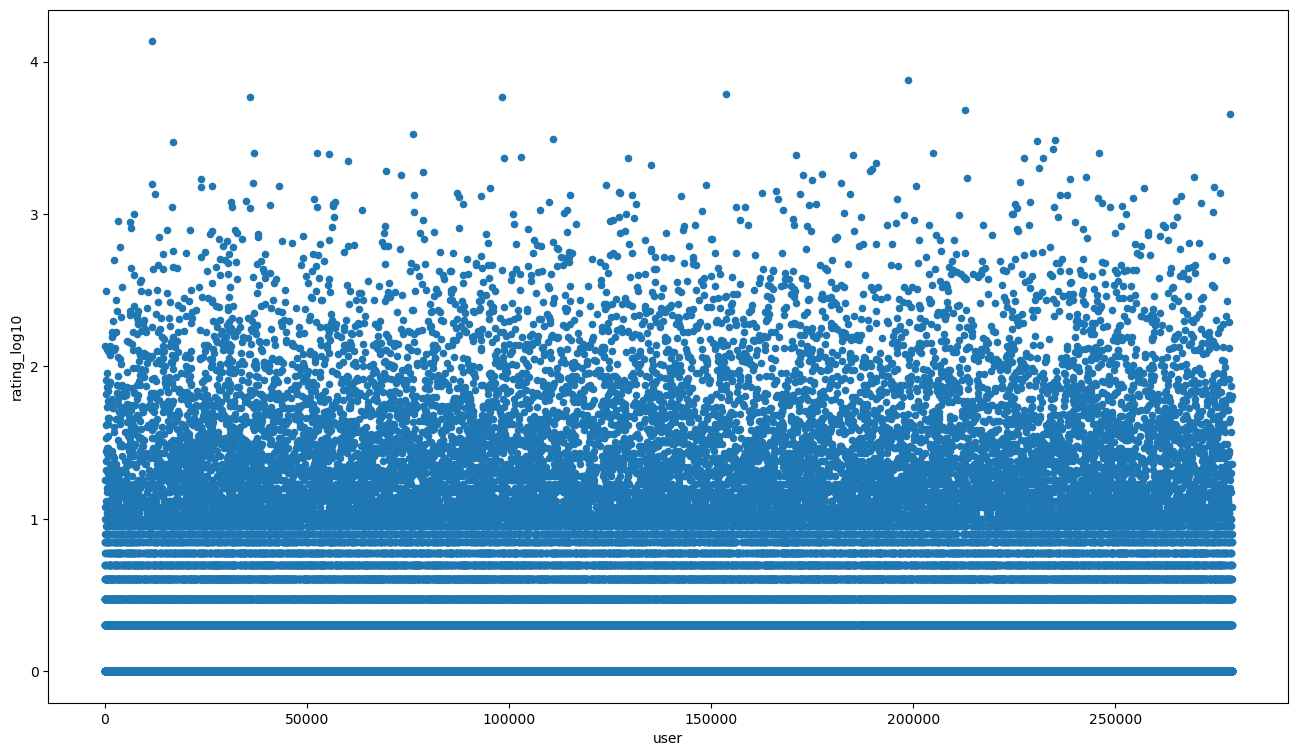

In [5]:
df = df_ratings[["user", "rating"]]\
    .groupby(["user"])\
    .count()\
    .reset_index()

df['rating_log10'] = np.log10(df['rating'])
df.plot.scatter(x="user", y="rating_log10")

From above graph, we can see the outlier who rarely rate the book.


Now, we first remove books that has less than 100 reviews.

In [6]:
dfb = df_ratings.groupby(["isbn"]).count().reset_index()
good_books = dfb.loc[dfb["rating"] >= 100]["isbn"]

# books contains those have no less than 100 ratings
good_books = df_books.loc[df_books["isbn"].isin(good_books)]

Now we can remove unqualified users

In [7]:
dfu = df_ratings[["user", "rating"]]\
    .groupby(["user"])\
    .count()\
    .reset_index()

good_users = dfu.loc[dfu["rating"] >= 200]["user"]

df = df_ratings.loc[df_ratings["user"].isin(good_users)]
df = df.loc[df["isbn"].isin(good_books["isbn"])]

For more efficient calculation and less memory footprint, we need to transform the values of the dataframe into a scipy sparse matrix.

In [8]:
# pivot ratings into book features
df_book_features = df.pivot(
    index='isbn',
    columns='user',
    values='rating'
).fillna(0)

# convert dataframe of book features to scipy sparse matrix
# this part requires a lot of memory!
mat_book_features = csr_matrix(df_book_features.values)

In [9]:
df_book_features.head()

user,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
isbn,,,,,,,,,,,,,,,,,,,,,
002542730X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0
0060008032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0060096195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
006016848X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0060173289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Create and fit the model with our book features

In [10]:
model = NearestNeighbors(metric='cosine')

model.fit(mat_book_features)

NearestNeighbors(metric='cosine')

Now we can implement the function.

In [11]:
# function to return recommended books - this will be tested
def get_recommends(title = ""):
    try:
        book = good_books.loc[good_books["title"] == title]
    except KeyError as e:
        print('Book', e, 'does not exist')
        return

    b = df_book_features.loc[df_book_features.index.isin(book["isbn"])]
    distance, indice = model.kneighbors([x for x in b.values], n_neighbors=6)

    distance =  distance[0][1:]
    indice = indice[0][1:]

    titles = [
        df_books.loc[df_books['isbn'] == df_book_features.iloc[i].name]["title"].values[0]\
        for i in indice
    ]

    recommended = [list(z) for z in zip(titles, distance)][::-1]
    return [title, recommended]

get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")

['The Queen of the Damned (Vampire Chronicles (Paperback))',
 [['Catch 22', 0.7939835],
  ['The Witching Hour (Lives of the Mayfair Witches)', 0.74486566],
  ['Interview with the Vampire', 0.73450685],
  ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.53763384],
  ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.51784116]]]

Use the cell below to test your function. The test_book_recommendation() function will inform you if you passed the challenge or need to keep trying.

## Test

In [12]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2):
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You havn't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8016211], ['The Weight of Water', 0.77085835], ['The Surgeon', 0.7699411], ['I Know This Much Is True', 0.7677075], ['The Lovely Bones: A Novel', 0.7234864]]]
You passed the challenge! 🎉🎉🎉🎉🎉
